# Obtencion de datos de suelo para Argentina, Uruguay, Paraguay y Chile

En esta notebook se vera un paso a paso de como se obtienen los datos de suelo de distintas fuentes y se cruzan con datos geograficos de zonas ecologicas y zonas de suelo.

Importacion de librerias necesarias

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import numpy as np
from pyproj import Transformer
from soilgrids import SoilGrids
from functools import reduce
import subprocess
import os
from os.path import exists
import re
import rasterio
from rasterio.plot import show

from country_bounding_boxes import (
      country_subunits_containing_point,
      country_subunits_by_iso_code
    )


from pyscripts.settings import output_dir, wosis_dir, data_dir
import pyscripts.utils as utils

## Wosis

Obtenemos los perfiles de las propiedades de carbono organico, arcilla, y bulk density de la base de datos de wosis. Para esto llamamos a un script en R que extrae la informacion de la base de datos. Se hace este proceso para cada pais y para cada material. 

In [2]:
countries = ['Argentina', 'Uruguay', 'Paraguay', 'Chile']
properties = ['profiles', 'orgc', 'clay', 'bdfi33']
path = 'wosis_latest/'

for country in countries:
    for prop in properties:
        filename = f'{wosis_dir}wosis_latest_{prop}_{country}.shp'
        if not exists(filename):
            subprocess.call([f"sudo Rscript gdal_wosis.R {country} shp {prop}"], shell=True)
            print(f'{filename} generated')
        else :
            print(f'{filename} already exists')

input_data/wosis_latest/wosis_latest_profiles_Argentina.shp already exists
input_data/wosis_latest/wosis_latest_orgc_Argentina.shp already exists
input_data/wosis_latest/wosis_latest_clay_Argentina.shp already exists
input_data/wosis_latest/wosis_latest_bdfi33_Argentina.shp already exists
input_data/wosis_latest/wosis_latest_profiles_Uruguay.shp already exists
input_data/wosis_latest/wosis_latest_orgc_Uruguay.shp already exists
input_data/wosis_latest/wosis_latest_clay_Uruguay.shp already exists
input_data/wosis_latest/wosis_latest_bdfi33_Uruguay.shp already exists
input_data/wosis_latest/wosis_latest_profiles_Paraguay.shp already exists
input_data/wosis_latest/wosis_latest_orgc_Paraguay.shp already exists
input_data/wosis_latest/wosis_latest_clay_Paraguay.shp already exists
input_data/wosis_latest/wosis_latest_bdfi33_Paraguay.shp already exists
input_data/wosis_latest/wosis_latest_profiles_Chile.shp already exists
input_data/wosis_latest/wosis_latest_orgc_Chile.shp already exists
inpu

Cada archivo contiene informacion sobre perfiles. Nos interesa unicamente los primeros 30cm de cada perfil, por lo que vamos a reducir la informacion de cada dataset obtenido a un promedio para los primeros 30cm de cada perfil.

Definimos la funcion que vamos a usar para calcular el ponderado promedio de los primeros 30cm de cada perfil. Para esto nos ayudamos de las columnas 'upper_depth' y 'lower_depth', que respectivamente indican los limites superiores e inferiores de cada capa (cada fila) del dataset

In [3]:
def poderate_avg(profiles, property, limit):
    col = property + '_value_avg'
    if(profiles['upper_depth'] > limit):
        return 0.0 

    if(profiles['lower_depth'] > limit):
        partial_depth = limit - profiles['upper_depth']
        return (partial_depth * profiles[col])/limit
    else:
        return ((profiles['lower_depth'] - profiles['upper_depth']) * profiles[col])/limit

Luego definimos una funcion que agrupe todas las filas de un dataset segun cada perfil, y devuelva unicamente el promedio ponderado de los primeros 30 cm del perfil, para una property particular

In [4]:
def get_profile_summary(df, property):
    prop_pond_col = property + '_pond_val'
    df[prop_pond_col] = df.apply(poderate_avg, args=(property, 30), axis=1)
    return df[['profile_id', 'country_name', prop_pond_col]].groupby(['profile_id', 'country_name']).sum().reset_index()

Luego escaneamos el directorio con los archivos descargados desde wosis para unirlos en un unico dataset con toda la informacion sumarizada. 

In [7]:
## we compose a regular expression to help us search for the files we want to process
countries = '|'.join(['Argentina', 'Uruguay', 'Paraguay', 'Chile'])
properties = '|'.join(['clay', 'orgc', 'bdfi33'])
format = 'csv' # format is fixed

files_re = re.compile(f'wosis_latest_({properties})_({countries}).{format}')
files = []

## scan local directory for shape files
with os.scandir(wosis_dir) as entries:
    for entry in entries:
        if re.search(files_re, entry.name):
            print(entry.name)
            files.append(entry.name)

## read all files into pandas dataframes and get summary from each one
group = []
countries = {}
for file in files:
    if(format == 'csv'):
        df = pd.read_csv(wosis_dir + file)
        property = file.split("_")[-2]
        country = file.split("_")[-1].split(".")[0]
        if country not in countries.keys():
            countries[country] = []
        countries[country].append(get_profile_summary(df, property))

## merge all dataframes
reduced_countries = {}
for key in countries:
    reduced_countries[key] = reduce(lambda l, r: pd.merge(l, r, on=['profile_id', 'country_name'], how='outer'), countries[key])
        
profille_summary = pd.concat(reduced_countries.values())
profille_summary

wosis_latest_clay_Argentina.csv
wosis_latest_orgc_Paraguay.csv
wosis_latest_orgc_Uruguay.csv
wosis_latest_bdfi33_Uruguay.csv
wosis_latest_clay_Chile.csv
wosis_latest_clay_Paraguay.csv
wosis_latest_clay_Uruguay.csv
wosis_latest_bdfi33_Argentina.csv
wosis_latest_orgc_Argentina.csv
wosis_latest_bdfi33_Paraguay.csv
wosis_latest_bdfi33_Chile.csv
wosis_latest_orgc_Chile.csv


profile_id country_name  clay_pond_val  bdfi33_pond_val  orgc_pond_val
0           63821    Argentina      45.533333              NaN      11.876667
1           63822    Argentina      12.500000              NaN       4.166667
2           63823    Argentina      16.133333              NaN       2.000000
3           63824    Argentina      31.666667              NaN      17.500000
4           63825    Argentina      10.533333              NaN      16.556667
...           ...          ...            ...              ...            ...
10786      732831        Chile            NaN              NaN     127.310000
10787      732832        Chile            NaN              NaN       2.000000
10788      732833        Chile            NaN              NaN       1.000000
10789      732834        Chile            NaN              NaN       4.000000
10790      732835        Chile            NaN              NaN       2.000000

[11177 rows x 5 columns]

In [8]:
profille_summary.country_name.value_counts()

Chile        10791
Argentina      249
Uruguay        136
Paraguay         1
Name: country_name, dtype: int64

## Obtencion de los valores de bulk_density estimados con Soilgrids

La base de datos de Wosis tiene muchos faltantes para los valores de bulk_density en los perfiles recuperados. Complementamos estos datos usando un archivo raster de soilgrids que contiene informacion estimada de bulk density. 

Hay un par de funciones por definir. En principio podemos obtener el bounding box para todos los paises pero posteriormente hay que convertir el sistema de coordenadas de uno elipsoidal a uno proyectado. Esto hace la funcion transform_crs.

Ademas, Soilgrids solo deja obtener la informacion de cierta profundidad de los perfiles. 0-5, 5-15 y 15-30. Vamos a obtener los raster para todas estas profundidades y, luego de samplear el raster, calculamos el ponderado. Lo hacemos de esta manera para evitar calcular el ponderado de muchos raster que no nos interesan. 

In [48]:
def transform_crs(crs_from, crs_to, bbox):
    t = Transformer.from_crs(crs_from=crs_from, crs_to=crs_to, always_xy=True)
    bbox[0], bbox[1] = t.transform(bbox[0], bbox[1])
    bbox[2], bbox[3] = t.transform(bbox[2], bbox[3])
    return bbox

def get_bulk_density(bbox, depth, file_id):
    # get data from SoilGrids
    soil_grids = SoilGrids()
    filename = f'{data_dir}soilgrids/{file_id}_{depth.replace("-","_")}_mean.tif'
    print('destination tif: ', filename)
    if not exists(filename):
        print('getting coverage data with bounding box:', bbox)
        data = soil_grids.get_coverage_data(service_id='bdod', coverage_id=f'bdod_{depth}cm_mean', 
                                            west=bbox[0], south=bbox[1], east=bbox[2], north=bbox[3],                                     
                                            crs='urn:ogc:def:crs:EPSG::3857', local_file=False,
                                            output=filename)
    else: 
        print(f'{filename} already exists')
    return rasterio.open(filename)

In [25]:
# split the bounding box to a matrix of boxes.
def bbox_split(bbox, splits):
    print('original bbox:', bbox)
    bboxes = []
    west_bound = bbox[0]
    south_bound = bbox[1]
    east_bound = bbox[2]
    north_bound = bbox[3]
    hdif = east_bound - west_bound
    vdif = north_bound - south_bound
    for i in range(splits):
        s = south_bound + i*vdif/splits
        n = s + vdif/splits
        for j in range(splits):   
            w = west_bound + j*hdif/splits
            e = w + hdif/splits
            bboxes.append([w, s, e, n])
    return bboxes

In [31]:
# split the bounding box vertically.
def bbox_split_v(bbox, splits):
    print('original bbox:', bbox)
    bboxes = []
    south_bound = bbox[1]
    north_bound = bbox[3]
    vdif = north_bound - south_bound
    for i in range(splits):
        s = south_bound + i*vdif/splits
        n = s + vdif/splits
        bboxes.append([bbox[0], s, bbox[2], n])
    return bboxes

In [26]:
# gets bounding box for each country in country codes and transforms crs from 4326 to 3857
def get_bboxes_and_transform(country_codes=['AR', 'UY', 'PY', 'CL']):
    bboxes = []
    for country_code in country_codes:
        bbox = list([c.bbox for c in country_subunits_by_iso_code(country_code)][0]) # returns tuple inside list
        bboxes.append(transform_crs("epsg:4326", "epsg:3857", bbox))
    return bboxes

In [29]:
splits = 3
bddata = []

for country_code in ['AR', 'UY', 'CL', 'PY']:
    for depth in ['0-5', '5-15', '15-30']:
        bbox = list([c.bbox for c in country_subunits_by_iso_code(country_code)][0]) # returns tuple inside list
        bbox = transform_crs("epsg:4326", "epsg:3857", bbox)

        if country_code in ['AR', 'CL']: # hacer un split vertical para chile
            bboxes = bbox_split_v(bbox, splits)
            for idx, bbox in enumerate(bboxes):
                bddata.append(get_bulk_density(bbox, depth, f'{country_code}_{idx}'))
        else:
            bddata.append(get_bulk_density(bbox, depth, country_code))

original bbox: [-8190472.858681833, -7368104.177131147, -5974356.179423455, -2487834.1351325694]
soilgrids/AR_0_0_5_mean.tif already exists
soilgrids/AR_1_0_5_mean.tif already exists
soilgrids/AR_2_0_5_mean.tif already exists
soilgrids/AR_3_0_5_mean.tif already exists
original bbox: [-8190472.858681833, -7368104.177131147, -5974356.179423455, -2487834.1351325694]
soilgrids/AR_0_5_15_mean.tif already exists
soilgrids/AR_1_5_15_mean.tif already exists
soilgrids/AR_2_5_15_mean.tif already exists
soilgrids/AR_3_5_15_mean.tif already exists
original bbox: [-8190472.858681833, -7368104.177131147, -5974356.179423455, -2487834.1351325694]
soilgrids/AR_0_15_30_mean.tif already exists
soilgrids/AR_1_15_30_mean.tif already exists
soilgrids/AR_2_15_30_mean.tif already exists
soilgrids/AR_3_15_30_mean.tif already exists
soilgrids/UY_0_5_mean.tif already exists
soilgrids/UY_5_15_mean.tif already exists
getting coverage data with bounding box: [-6505303.405015289, -4154754.3755499045, -5913913.174656

Exception: WCS sever error 
<?xml version='1.0' encoding="UTF-8" ?>
<ServiceExceptionReport version="1.2.0"
xmlns="http://www.opengis.net/ogc" xmlns:xsi="http://www.w3.org/2001/XMLSchema-instance" xsi:schemaLocation="http://www.opengis.net/ogc http://schemas.opengis.net/wcs/1.0.0/OGC-exception.xsd">
  <ServiceException code="InvalidParameterValue" locator="width/height">msWCSGetCoverage(): WCS server error. Raster size out of range, width and height of resulting coverage must be no more than MAXSIZE=16384.
  </ServiceException>
</ServiceExceptionReport>


In [60]:
## FETCH RASTER FILES FOR PARAGUAY FOR DEPTH 0-30
ccode = 'PY'
cname = 'Paraguay'
splits = 2
bddata = []
bbox = list([c.bbox for c in country_subunits_by_iso_code(ccode)][0]) # returns tuple inside list
bbox = transform_crs("epsg:4326", "epsg:3857", bbox)
for depth in ['0-5', '5-15', '15-30']:
    bddata.append(get_bulk_density(bbox, depth, f'{ccode}'))

destination tif:  soilgrids/PY_0_5_mean.tif
getting coverage data with bounding box: [-6974274.808638817, -3192834.84175329, -6038169.207837177, -2188664.071954172]
destination tif:  soilgrids/PY_5_15_mean.tif
soilgrids/PY_5_15_mean.tif already exists
destination tif:  soilgrids/PY_15_30_mean.tif
getting coverage data with bounding box: [-6974274.808638817, -3192834.84175329, -6038169.207837177, -2188664.071954172]


In [59]:
## FETCH RASTER FILES FOR ARGENTINA FOR DEPTH 0-30
ccode = 'AR'
cname = 'Argentina'
splits = 2
bddata = []
bbox = list([c.bbox for c in country_subunits_by_iso_code(ccode)][0]) # returns tuple inside list
bbox = transform_crs("epsg:4326", "epsg:3857", bbox)
bboxes = bbox_split_v(bbox, splits)
for idx, bbox in enumerate(bboxes):
    for depth in ['0-5', '5-15', '15-30']:
        bddata.append(get_bulk_density(bbox, depth, f'{ccode}_{idx}'))

original bbox: [-8190472.858681833, -7368104.177131147, -5974356.179423455, -2487834.1351325694]
destination tif:  soilgrids/AR_0_0_5_mean.tif
soilgrids/AR_0_0_5_mean.tif already exists
destination tif:  soilgrids/AR_0_5_15_mean.tif
getting coverage data with bounding box: [-8190472.858681833, -7368104.177131147, -5974356.179423455, -4927969.156131858]
destination tif:  soilgrids/AR_0_15_30_mean.tif
getting coverage data with bounding box: [-8190472.858681833, -7368104.177131147, -5974356.179423455, -4927969.156131858]
destination tif:  soilgrids/AR_1_0_5_mean.tif
soilgrids/AR_1_0_5_mean.tif already exists
destination tif:  soilgrids/AR_1_5_15_mean.tif
getting coverage data with bounding box: [-8190472.858681833, -4927969.156131858, -5974356.179423455, -2487834.135132569]
destination tif:  soilgrids/AR_1_15_30_mean.tif
getting coverage data with bounding box: [-8190472.858681833, -4927969.156131858, -5974356.179423455, -2487834.135132569]


In [58]:
## FETCH RASTER FILES FOR CHILE FOR DEPTH 0-30
ccode = 'CL'
cname = 'Chile'
splits = 4
bddata = []
bbox = list([c.bbox for c in country_subunits_by_iso_code(ccode)][0]) # returns tuple inside list
bbox = transform_crs("epsg:4326", "epsg:3857", bbox)
bboxes = bbox_split_v(bbox, splits)
for idx, bbox in enumerate(bboxes):
    for depth in ['0-5', '5-15', '15-30']:
        bddata.append(get_bulk_density(bbox, depth, f'{ccode}_{idx}'))

original bbox: [-8427787.749699134, -7536886.1733710645, -7395598.426304933, -1979813.2250887163]
destination tif:  soilgrids/CL_0_0_5_mean.tif
soilgrids/CL_0_0_5_mean.tif already exists
destination tif:  soilgrids/CL_0_5_15_mean.tif
getting coverage data with bounding box: [-8427787.749699134, -7536886.1733710645, -7395598.426304933, -6147617.936300477]
destination tif:  soilgrids/CL_0_15_30_mean.tif
getting coverage data with bounding box: [-8427787.749699134, -7536886.1733710645, -7395598.426304933, -6147617.936300477]
destination tif:  soilgrids/CL_1_0_5_mean.tif
soilgrids/CL_1_0_5_mean.tif already exists
destination tif:  soilgrids/CL_1_5_15_mean.tif
getting coverage data with bounding box: [-8427787.749699134, -6147617.936300477, -7395598.426304933, -4758349.6992298905]
destination tif:  soilgrids/CL_1_15_30_mean.tif
getting coverage data with bounding box: [-8427787.749699134, -6147617.936300477, -7395598.426304933, -4758349.6992298905]
destination tif:  soilgrids/CL_2_0_5_mean.

original bbox: [-8190472.858681833, -7368104.177131147, -5974356.179423455, -2487834.1351325694]
destination tif:  soilgrids/AR_0_0_5_mean.tif
soilgrids/AR_0_0_5_mean.tif already exists
destination tif:  soilgrids/AR_1_0_5_mean.tif
soilgrids/AR_1_0_5_mean.tif already exists
AR_0_0_5_mean.tif
AR_1_0_5_mean.tif


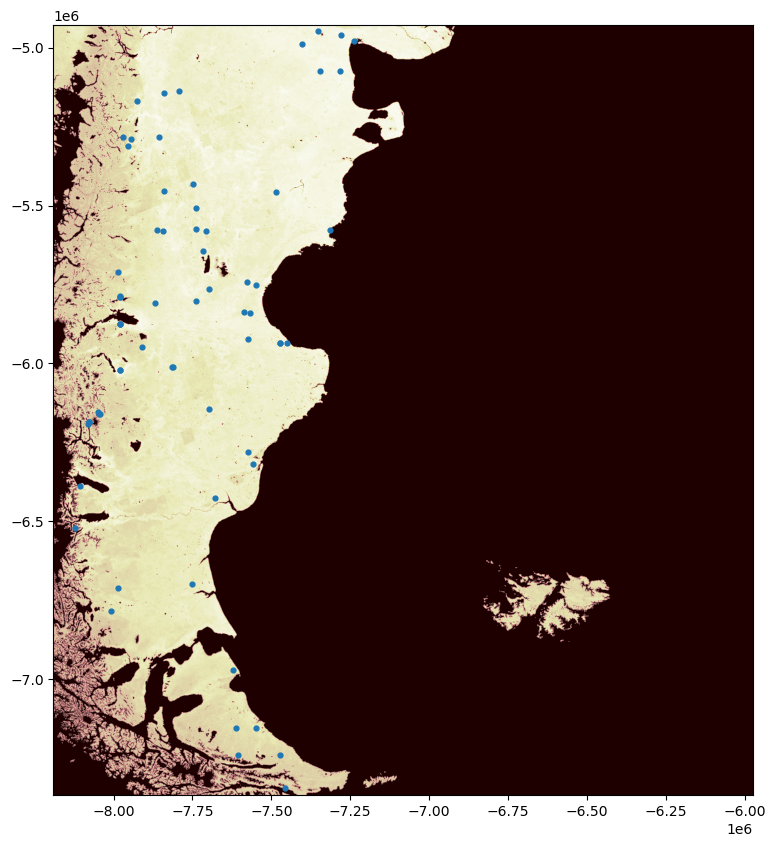

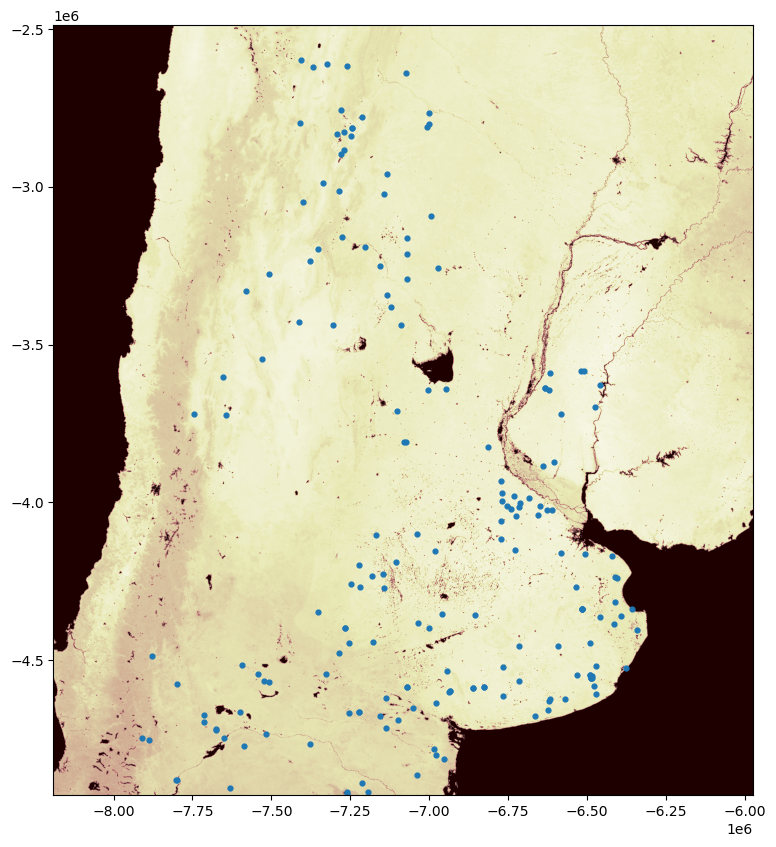

In [57]:
## RASTER FILES FOR ARGENTINA

bddata = []
bbox = list([c.bbox for c in country_subunits_by_iso_code('AR')][0]) # returns tuple inside list
bbox = transform_crs("epsg:4326", "epsg:3857", bbox)
bboxes = bbox_split_v(bbox, 2)
for idx, bbox in enumerate(bboxes):
    bddata.append(get_bulk_density(bbox, '0-5', f'AR_{idx}'))

gdf = gpd.read_file("wosis_latest/wosis_latest_profiles_Argentina.shp").to_crs("EPSG:3857")

country_format = 'AR_'
files_re = re.compile(f'{country_format}[\w]*')
files = []
parent_dir = './soilgrids/'

## scan local directory for shape files
with os.scandir(parent_dir) as entries:
    for entry in entries:
        if re.search(files_re, entry.name):
            print(entry.name)
            files.append(parent_dir + entry.name)
files.sort()

for file, bbox in zip(files, bboxes):
    src = rasterio.open(file)
    fig, ax = plt.subplots(figsize=(12, 10))

    # transform rasterio plot to real world coords
    extent=[src.bounds[0], src.bounds[2], src.bounds[1], src.bounds[3]]
    ax = rasterio.plot.show(src, extent=extent, ax=ax, cmap='pink')
    gdf.cx[bbox[0]:bbox[2], bbox[1]:bbox[3]].plot(ax=ax, markersize=12)

original bbox: [-8427787.749699134, -7536886.1733710645, -7395598.426304933, -1979813.2250887163]
destination tif:  soilgrids/CL_0_0_5_mean.tif
soilgrids/CL_0_0_5_mean.tif already exists
destination tif:  soilgrids/CL_1_0_5_mean.tif
soilgrids/CL_1_0_5_mean.tif already exists
destination tif:  soilgrids/CL_2_0_5_mean.tif
soilgrids/CL_2_0_5_mean.tif already exists
destination tif:  soilgrids/CL_3_0_5_mean.tif
soilgrids/CL_3_0_5_mean.tif already exists
CL_1_0_5_mean.tif
CL_3_0_5_mean.tif
CL_0_0_5_mean.tif
CL_2_0_5_mean.tif


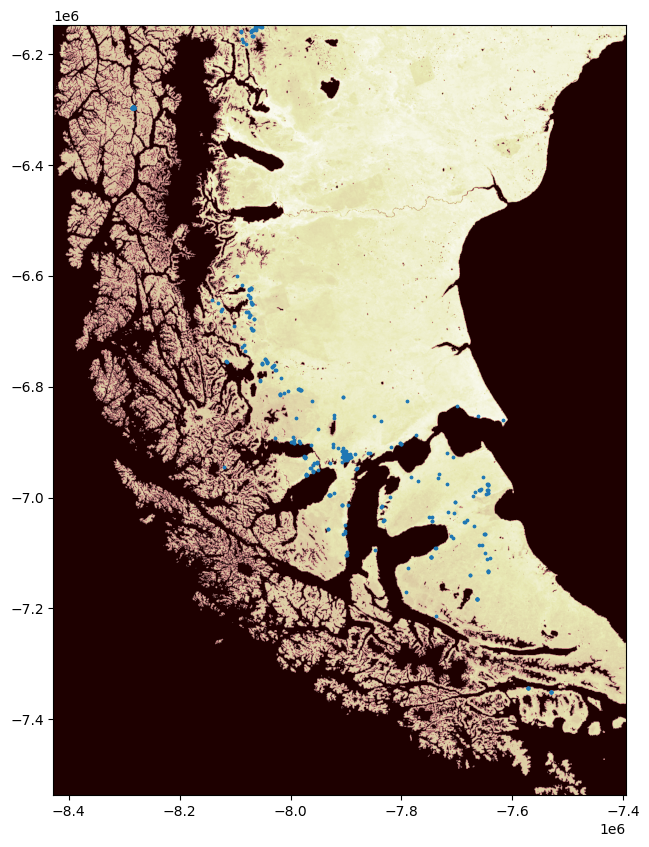

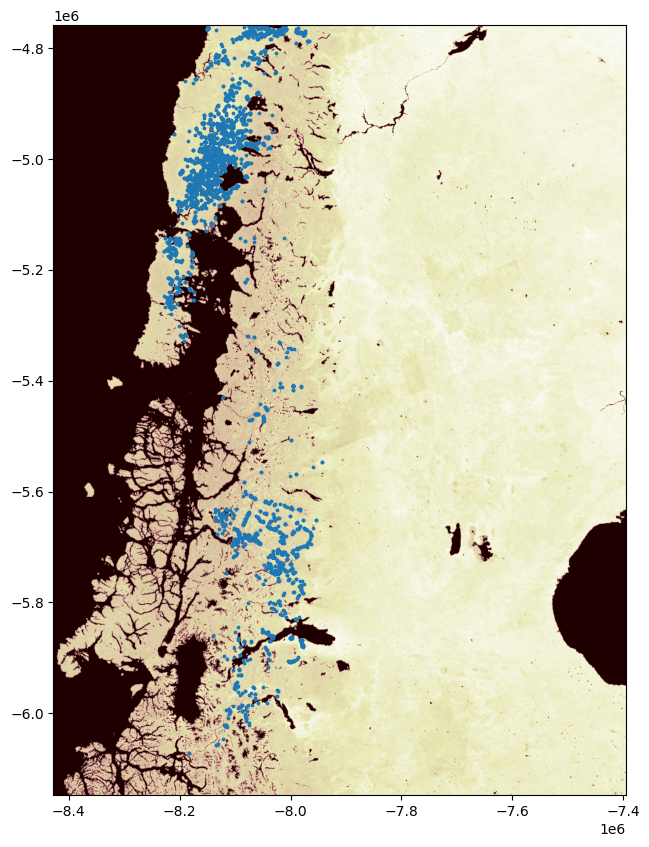

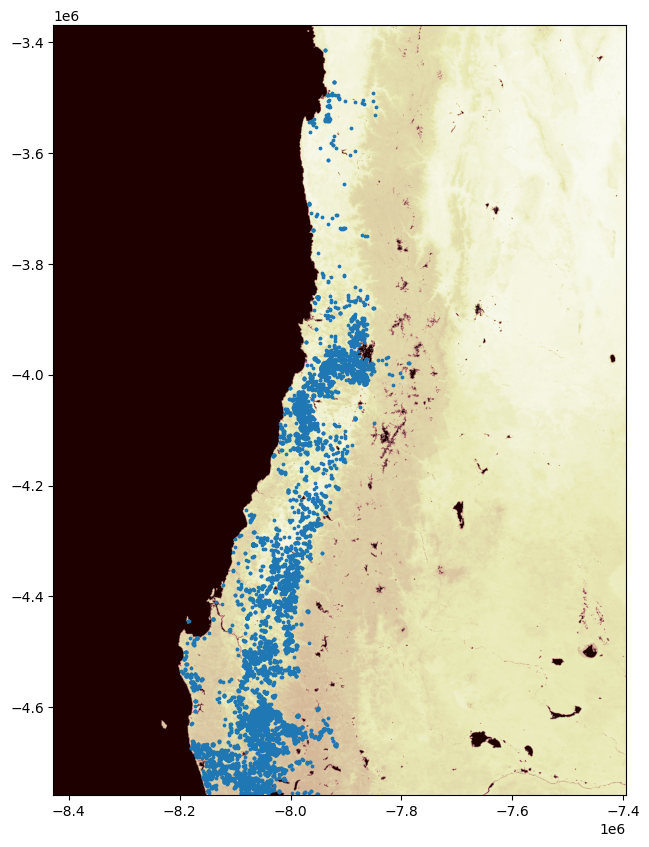

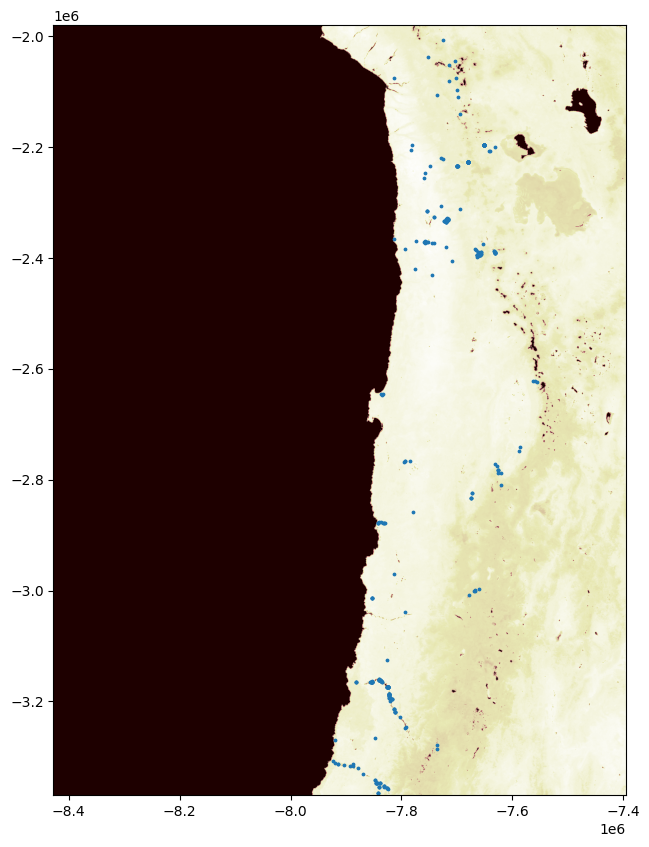

In [53]:
## RASTER FILES FOR CHILE
ccode = 'CL'
cname = 'Chile'
splits = 4
bddata = []
bbox = list([c.bbox for c in country_subunits_by_iso_code(ccode)][0]) # returns tuple inside list
bbox = transform_crs("epsg:4326", "epsg:3857", bbox)
bboxes = bbox_split_v(bbox, splits)
for idx, bbox in enumerate(bboxes):
    bddata.append(get_bulk_density(bbox, '0-5', f'{ccode}_{idx}'))

gdf = gpd.read_file(f"wosis_latest/wosis_latest_profiles_{cname}.shp").to_crs("EPSG:3857")

country_format = f'{ccode}_'
files_re = re.compile(f'{country_format}[\w]*')
files = []
parent_dir = './soilgrids/'

## scan local directory for shape files
with os.scandir(parent_dir) as entries:
    for entry in entries:
        if re.search(files_re, entry.name):
            print(entry.name)
            files.append(parent_dir + entry.name)
files.sort()

for file, bbox in zip(files, bboxes):
    src = rasterio.open(file)
    fig, ax = plt.subplots(figsize=(12, 10))

    # transform rasterio plot to real world coords
    extent=[src.bounds[0], src.bounds[2], src.bounds[1], src.bounds[3]]
    ax = rasterio.plot.show(src, extent=extent, ax=ax, cmap='pink')
    gdf.cx[bbox[0]:bbox[2], bbox[1]:bbox[3]].plot(ax=ax, markersize=3)

destination tif:  soilgrids/UY_0_5_mean.tif
soilgrids/UY_0_5_mean.tif already exists


<AxesSubplot: >

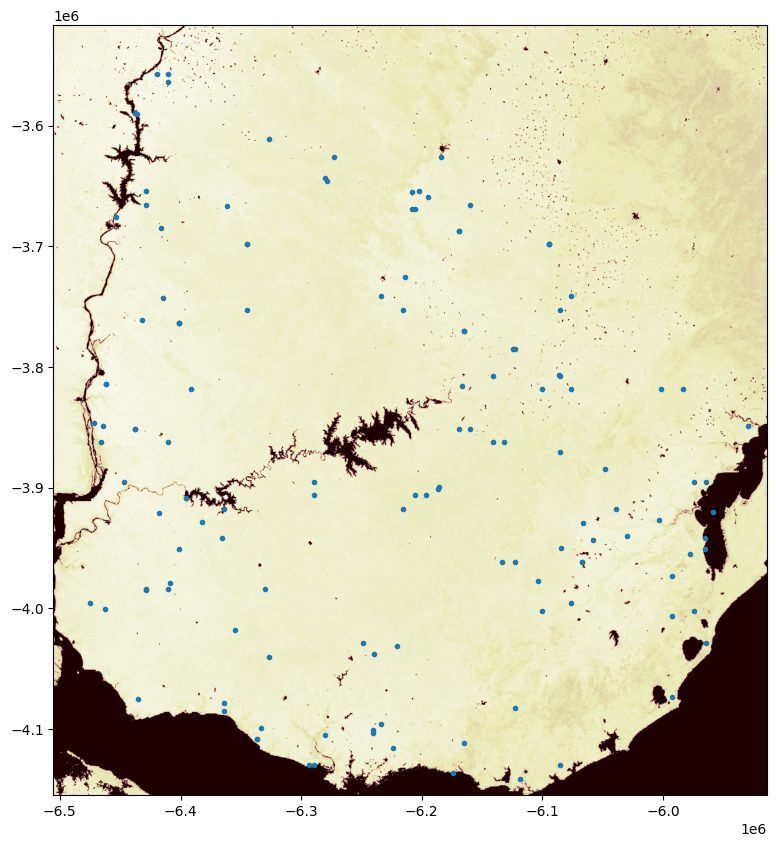

In [55]:
## RASTER FILES FOR Uruguay
ccode = 'UY'
cname = 'Uruguay'
bddata = []
bbox = list([c.bbox for c in country_subunits_by_iso_code(ccode)][0]) # returns tuple inside list
bbox = transform_crs("epsg:4326", "epsg:3857", bbox)
bddata.append(get_bulk_density(bbox, '0-5', f'{ccode}'))

gdf = gpd.read_file(f"wosis_latest/wosis_latest_profiles_{cname}.shp").to_crs("EPSG:3857")

parent_dir = './soilgrids/'
file = f'{parent_dir}{ccode}_0_5_mean.tif'

src = rasterio.open(file)
fig, ax = plt.subplots(figsize=(12, 10))

# transform rasterio plot to real world coords
extent=[src.bounds[0], src.bounds[2], src.bounds[1], src.bounds[3]]
ax = rasterio.plot.show(src, extent=extent, ax=ax, cmap='pink')
gdf.plot(ax=ax, markersize=9)

## Ponderado de bulk density para 0-30 cm

In [142]:
gdf_bd_pond_uy = gpd.read_file(f"wosis_latest/wosis_latest_profiles_Uruguay.shp").to_crs("EPSG:3857")
total_depth = 30

for depth_code, depth in zip(['0_5', '5_15', '15_30'],[5, 10, 15]):
    src = rasterio.open(f'soilgrids/UY_{depth_code}_mean.tif')
    coord_list = [(x,y) for x,y in zip(gdf_bd_pond_uy['geometry'].x , gdf_bd_pond_uy['geometry'].y)]
    gdf_bd_pond_uy[f'bd_{depth_code}_RAW'] = [x for x in src.sample(coord_list)]

gdf_bd_pond_uy.head()

gml_id  profile_id           dataset_id continent  \
0  wosis_latest_profiles.623792      623792       {WD-NWAFU-SCS}  Americas   
1   wosis_latest_profiles.69741       69741    {WD-ISIS,WD-WISE}  Americas   
2   wosis_latest_profiles.69609       69609    {WD-ISIS,WD-WISE}  Americas   
3   wosis_latest_profiles.70922       70922  {LAC-SOTER,WD-WISE}  Americas   
4   wosis_latest_profiles.68675       68675            {WD-WISE}  Americas   

  country_id country_na  geom_accur   latitude  longitude  dsds  ...  wg1500  \
0         UY    Uruguay    0.000001 -34.616665 -55.383335    10  ...   false   
1         UY    Uruguay    0.100000 -31.083333 -56.416667   153  ...   false   
2         UY    Uruguay    0.100000 -32.666667 -57.833333   137  ...   false   
3         UY    Uruguay    0.010000 -33.099722 -57.450000   114  ...   false   
4         UY    Uruguay    0.100000 -34.366667 -57.166667    97  ...   false   

  wv0010 wv0033 wv0100 wv0500  wv1500                           geometry  \
0  false  false  false  false   false  POINT (-6165244.651 -4111908.705)   
1  false  false  false  false   false  POINT (-6280274.643 -3643576.255)   
2  false  false  false  false   false  POINT (-6437977.180 -3851142.704)   
3  false  false  false  false   false  POINT (-6395304.746 -3908547.884)   
4  false  false  false  false   false  POINT (-6363764.261 -4078143.352)   

  bd_0_5_RAW bd_5_15_RAW bd_15_30_RAW  
0      [128]       [134]        [139]  
1      [132]       [138]        [151]  
2      [143]       [151]        [160]  
3        [0]         [0]          [0]  
4      [137]       [147]        [160]  

[5 rows x 74 columns]

In [143]:
gdf_bd_pond_uy = gpd.read_file(f"wosis_latest/wosis_latest_profiles_Uruguay.shp").to_crs("EPSG:3857")
total_depth = 30

for depth_code, depth in zip(['0_5', '5_15', '15_30'],[5, 10, 15]):
    src = rasterio.open(f'soilgrids/UY_{depth_code}_mean.tif')
    coord_list = [(x,y) for x,y in zip(gdf_bd_pond_uy['geometry'].x , gdf_bd_pond_uy['geometry'].y)]
    gdf_bd_pond_uy[f'bd_{depth_code}_ponderated'] = [(x/100)*depth / total_depth for x in src.sample(coord_list)]

gdf_bd_pond_uy.head()

gml_id  profile_id           dataset_id continent  \
0  wosis_latest_profiles.623792      623792       {WD-NWAFU-SCS}  Americas   
1   wosis_latest_profiles.69741       69741    {WD-ISIS,WD-WISE}  Americas   
2   wosis_latest_profiles.69609       69609    {WD-ISIS,WD-WISE}  Americas   
3   wosis_latest_profiles.70922       70922  {LAC-SOTER,WD-WISE}  Americas   
4   wosis_latest_profiles.68675       68675            {WD-WISE}  Americas   

  country_id country_na  geom_accur   latitude  longitude  dsds  ...  wg1500  \
0         UY    Uruguay    0.000001 -34.616665 -55.383335    10  ...   false   
1         UY    Uruguay    0.100000 -31.083333 -56.416667   153  ...   false   
2         UY    Uruguay    0.100000 -32.666667 -57.833333   137  ...   false   
3         UY    Uruguay    0.010000 -33.099722 -57.450000   114  ...   false   
4         UY    Uruguay    0.100000 -34.366667 -57.166667    97  ...   false   

  wv0010 wv0033 wv0100 wv0500  wv1500                           geometry  \
0  false  false  false  false   false  POINT (-6165244.651 -4111908.705)   
1  false  false  false  false   false  POINT (-6280274.643 -3643576.255)   
2  false  false  false  false   false  POINT (-6437977.180 -3851142.704)   
3  false  false  false  false   false  POINT (-6395304.746 -3908547.884)   
4  false  false  false  false   false  POINT (-6363764.261 -4078143.352)   

       bd_0_5_ponderated     bd_5_15_ponderated bd_15_30_ponderated  
0  [0.21333333333333335]  [0.44666666666666666]             [0.695]  
1  [0.22000000000000003]  [0.45999999999999996]             [0.755]  
2   [0.2383333333333333]   [0.5033333333333333]               [0.8]  
3                  [0.0]                  [0.0]               [0.0]  
4  [0.22833333333333336]                 [0.49]               [0.8]  

[5 rows x 74 columns]

In [144]:
gdf_bd_pond_uy[f'bd_0_30_ponderated'] = gdf_bd_pond_uy.apply(lambda x: x['bd_0_5_ponderated'] + x['bd_5_15_ponderated'] + x['bd_15_30_ponderated'], axis=1)
gdf_bd_pond_uy.head()

gml_id  profile_id           dataset_id continent  \
0  wosis_latest_profiles.623792      623792       {WD-NWAFU-SCS}  Americas   
1   wosis_latest_profiles.69741       69741    {WD-ISIS,WD-WISE}  Americas   
2   wosis_latest_profiles.69609       69609    {WD-ISIS,WD-WISE}  Americas   
3   wosis_latest_profiles.70922       70922  {LAC-SOTER,WD-WISE}  Americas   
4   wosis_latest_profiles.68675       68675            {WD-WISE}  Americas   

  country_id country_na  geom_accur   latitude  longitude  dsds  ...  wv0010  \
0         UY    Uruguay    0.000001 -34.616665 -55.383335    10  ...   false   
1         UY    Uruguay    0.100000 -31.083333 -56.416667   153  ...   false   
2         UY    Uruguay    0.100000 -32.666667 -57.833333   137  ...   false   
3         UY    Uruguay    0.010000 -33.099722 -57.450000   114  ...   false   
4         UY    Uruguay    0.100000 -34.366667 -57.166667    97  ...   false   

  wv0033 wv0100 wv0500 wv1500                           geometry  \
0  false  false  false  false  POINT (-6165244.651 -4111908.705)   
1  false  false  false  false  POINT (-6280274.643 -3643576.255)   
2  false  false  false  false  POINT (-6437977.180 -3851142.704)   
3  false  false  false  false  POINT (-6395304.746 -3908547.884)   
4  false  false  false  false  POINT (-6363764.261 -4078143.352)   

       bd_0_5_ponderated     bd_5_15_ponderated bd_15_30_ponderated  \
0  [0.21333333333333335]  [0.44666666666666666]             [0.695]   
1  [0.22000000000000003]  [0.45999999999999996]             [0.755]   
2   [0.2383333333333333]   [0.5033333333333333]               [0.8]   
3                  [0.0]                  [0.0]               [0.0]   
4  [0.22833333333333336]                 [0.49]               [0.8]   

     bd_0_30_ponderated  
0               [1.355]  
1               [1.435]  
2  [1.5416666666666665]  
3                 [0.0]  
4  [1.5183333333333335]  

[5 rows x 75 columns]

In [ ]:
def get_profile_summary(df, property):
    prop_pond_col = property + '_pond_val'
    df[prop_pond_col] = df.apply(poderate_avg, args=(property, 30), axis=1)
    return df[['profile_id', 'country_name', prop_pond_col]].groupby(['profile_id', 'country_name']).sum().reset_index()

# Zonas Ecologicas

Obtenemos los nombres de las zonas ecologicas desde un archivo externo, y lo unimos a nuestro set de datos

In [9]:
with open(data_dir + 'ecozone_names.txt', 'r') as ecozones:
    zones = ecozones.readlines()
zone_names = list(map(utils.zone_names, zones))
levels = list(map(utils.levels, zones))
df_level_zone = pd.DataFrame(list(zip(levels, zone_names)), columns=['level', 'zone_name'])
df_level_zone

level                                          zone_name
0        13                                  Temperate Sierras
1      13.6  Central American Sierra Madre and Chiapas High...
2    13.6.1                Northern Central American Highlands
3    13.6.2                      Central American Sierra Madre
4    13.6.4             Altos de Chiapas con bosque mesoÃ³filo
..      ...                                                ...
162    24.2                              Patagonian Tablelands
163  24.2.1                                 Northern Patagonia
164  24.2.2                                 Southern Patagonia
165  24.2.3                                Magellan Grasslands
166      25                                          Galapagos

[167 rows x 2 columns]

In [10]:
gdf_country_shapes = gpd.read_file(data_dir + "remapasdesuelo/paisesCopy_ll-wgs84.shp").to_crs("EPSG:3857")

<AxesSubplot: >

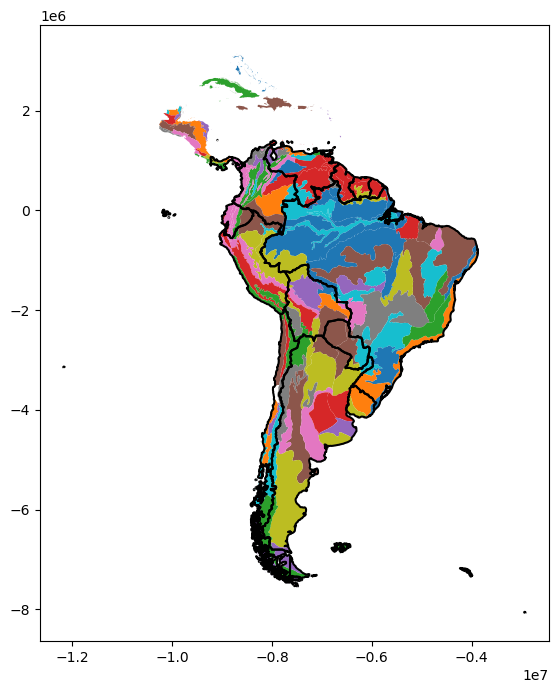

In [106]:
gdf_ecoregions = gpd.read_file(data_dir + "sa_eco_13/sa_eco_l3.shp").to_crs("EPSG:3857")
gdf_ecoregions = gdf_ecoregions.merge(df_level_zone, left_on='LEVEL3', right_on='level')
fig, ax = plt.subplots(1, 1, figsize=(15,8))
gdf_ecoregions.plot(column='zone_name', ax = ax)
gdf_country_shapes.boundary.plot(ax = ax, color='black')


## Zonas ecologicas para Argentina, Uruguay, Paraguay y Chile

In [75]:
def get_profiles_and_transform(countries=['Argentina', 'Uruguay', 'Paraguay', 'Chile']):
    gdfs = []
    for country in countries:
        file = f"{wosis_dir}wosis_latest_profiles_{country}.shp"
        gdf = gpd.read_file(file)
        gdfs.append(gdf.to_crs("EPSG:3857"))
    return gdfs

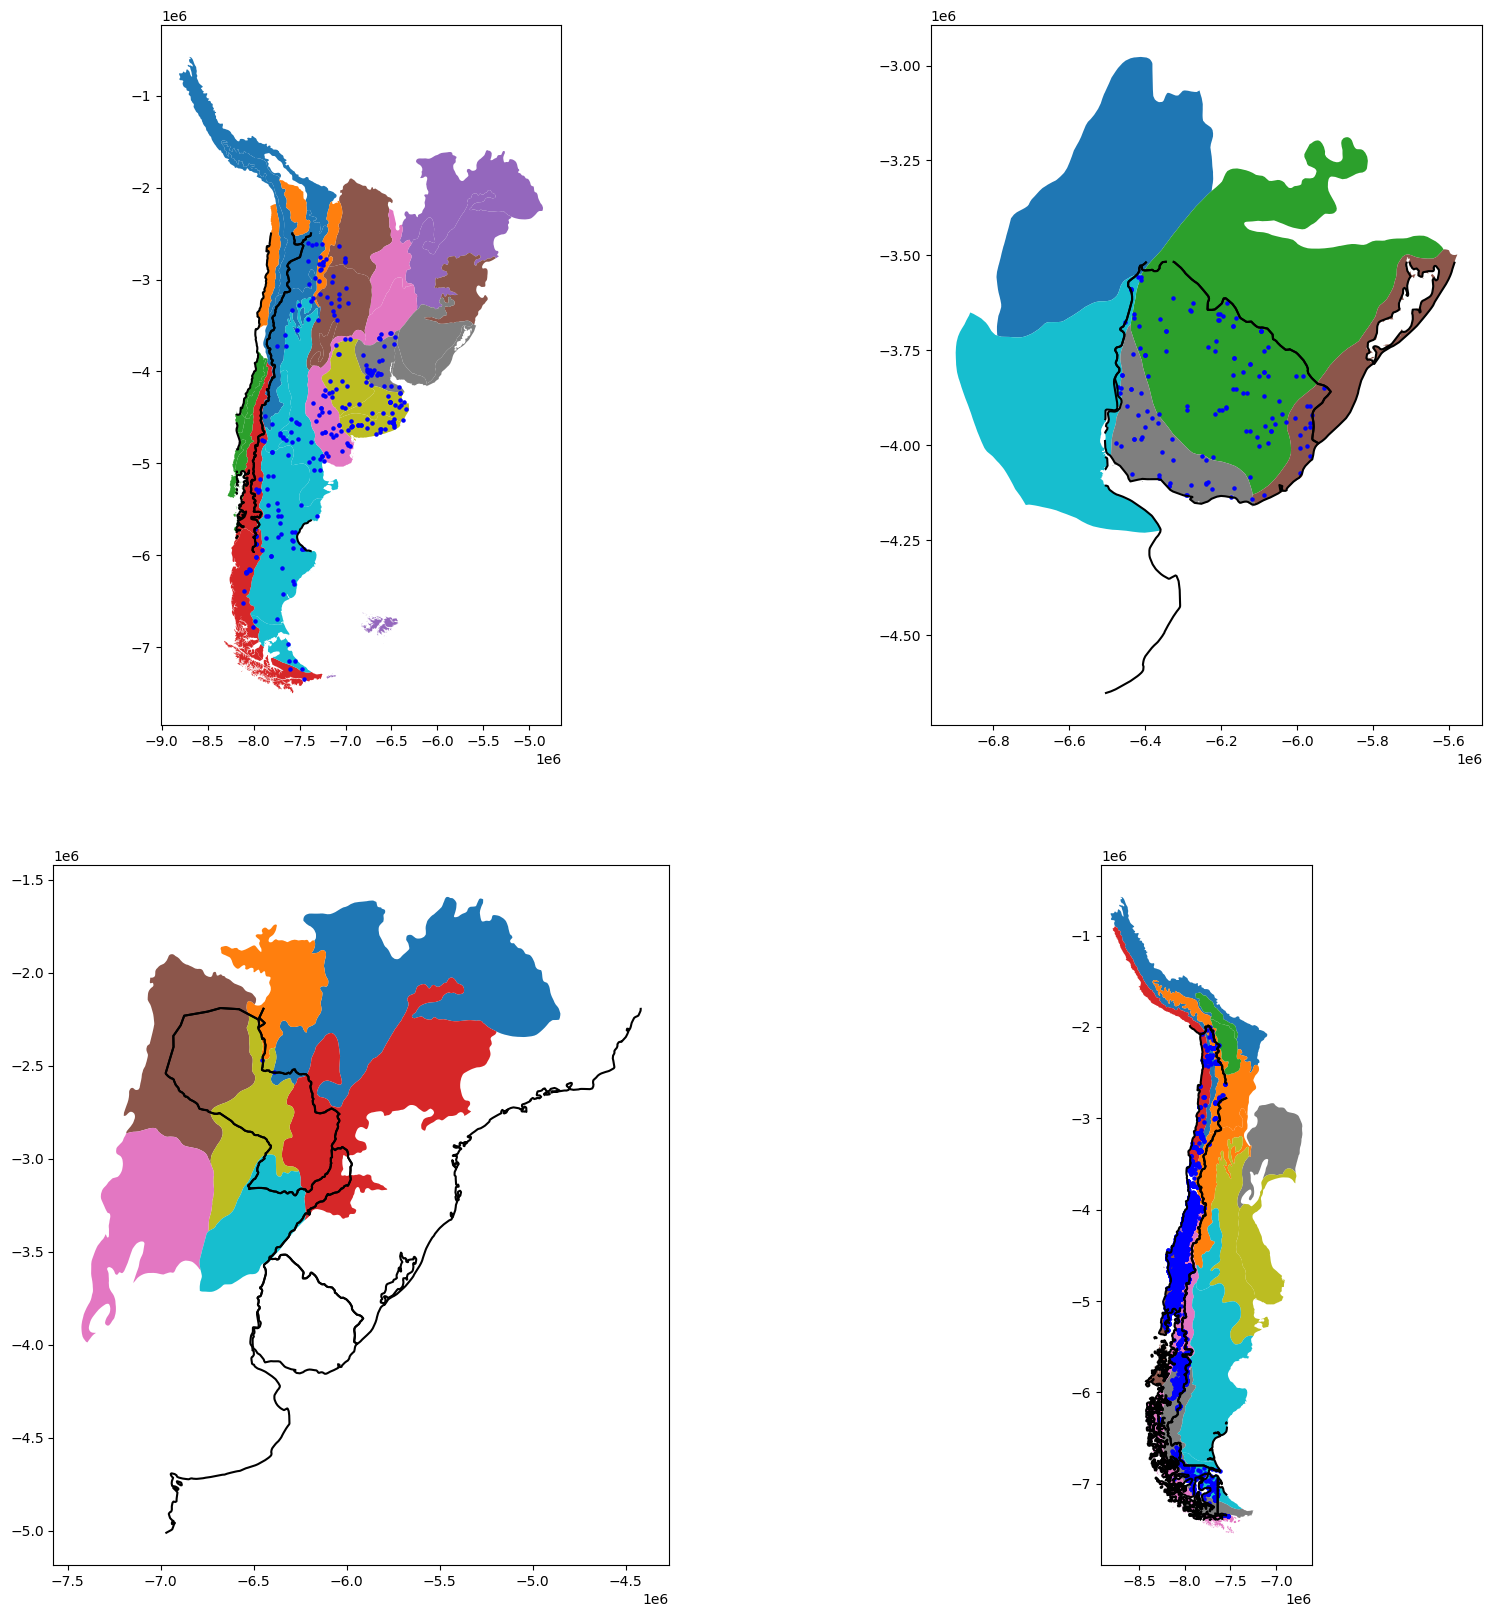

In [81]:
bboxes = get_bboxes_and_transform()
profiles = get_profiles_and_transform()
n = 2

fig, axes = plt.subplots(n, n, figsize=(20,20))

for i in range(n):
    for j in range(n):
        bbox = bboxes[j+i*n]
        base = gdf_ecoregions.cx[bbox[0]:bbox[2], bbox[1]:bbox[3]].plot(column='level', ax=axes[i][j])
        profiles[j+i*n].plot(ax=base, marker='o', color='blue', markersize=5)
        gdf_country_shapes.boundary.clip(mask=(bbox[0], bbox[2], bbox[1], bbox[3])).plot(ax = base, color='black')


# Zonas de suelo

<AxesSubplot: >

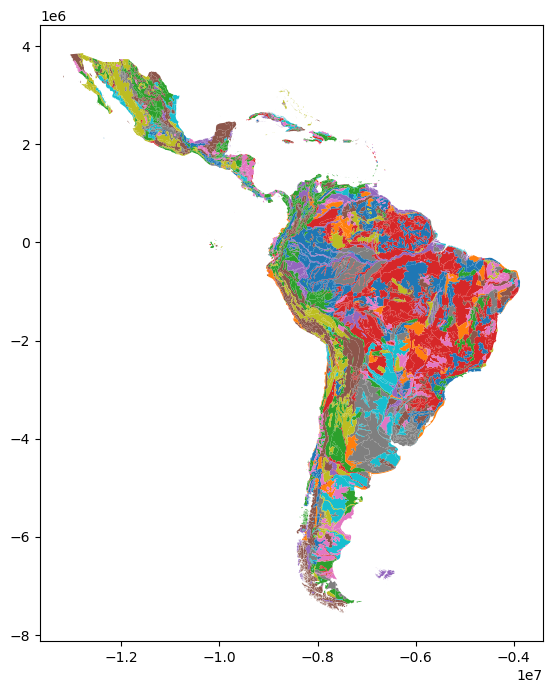

In [107]:
gdf_soils = gpd.read_file("LAC-SOTER/SOTERLAC/GIS/SOTER/SOTERLACv2.shp").to_crs("EPSG:3857")
fig, ax = plt.subplots(1, 1, figsize=(15,8))
gdf_soils.plot(column="DOMSOIL_UN", ax=ax)


### Zonas de suelo para Argentina, Uruguay, Paraguay y Chile

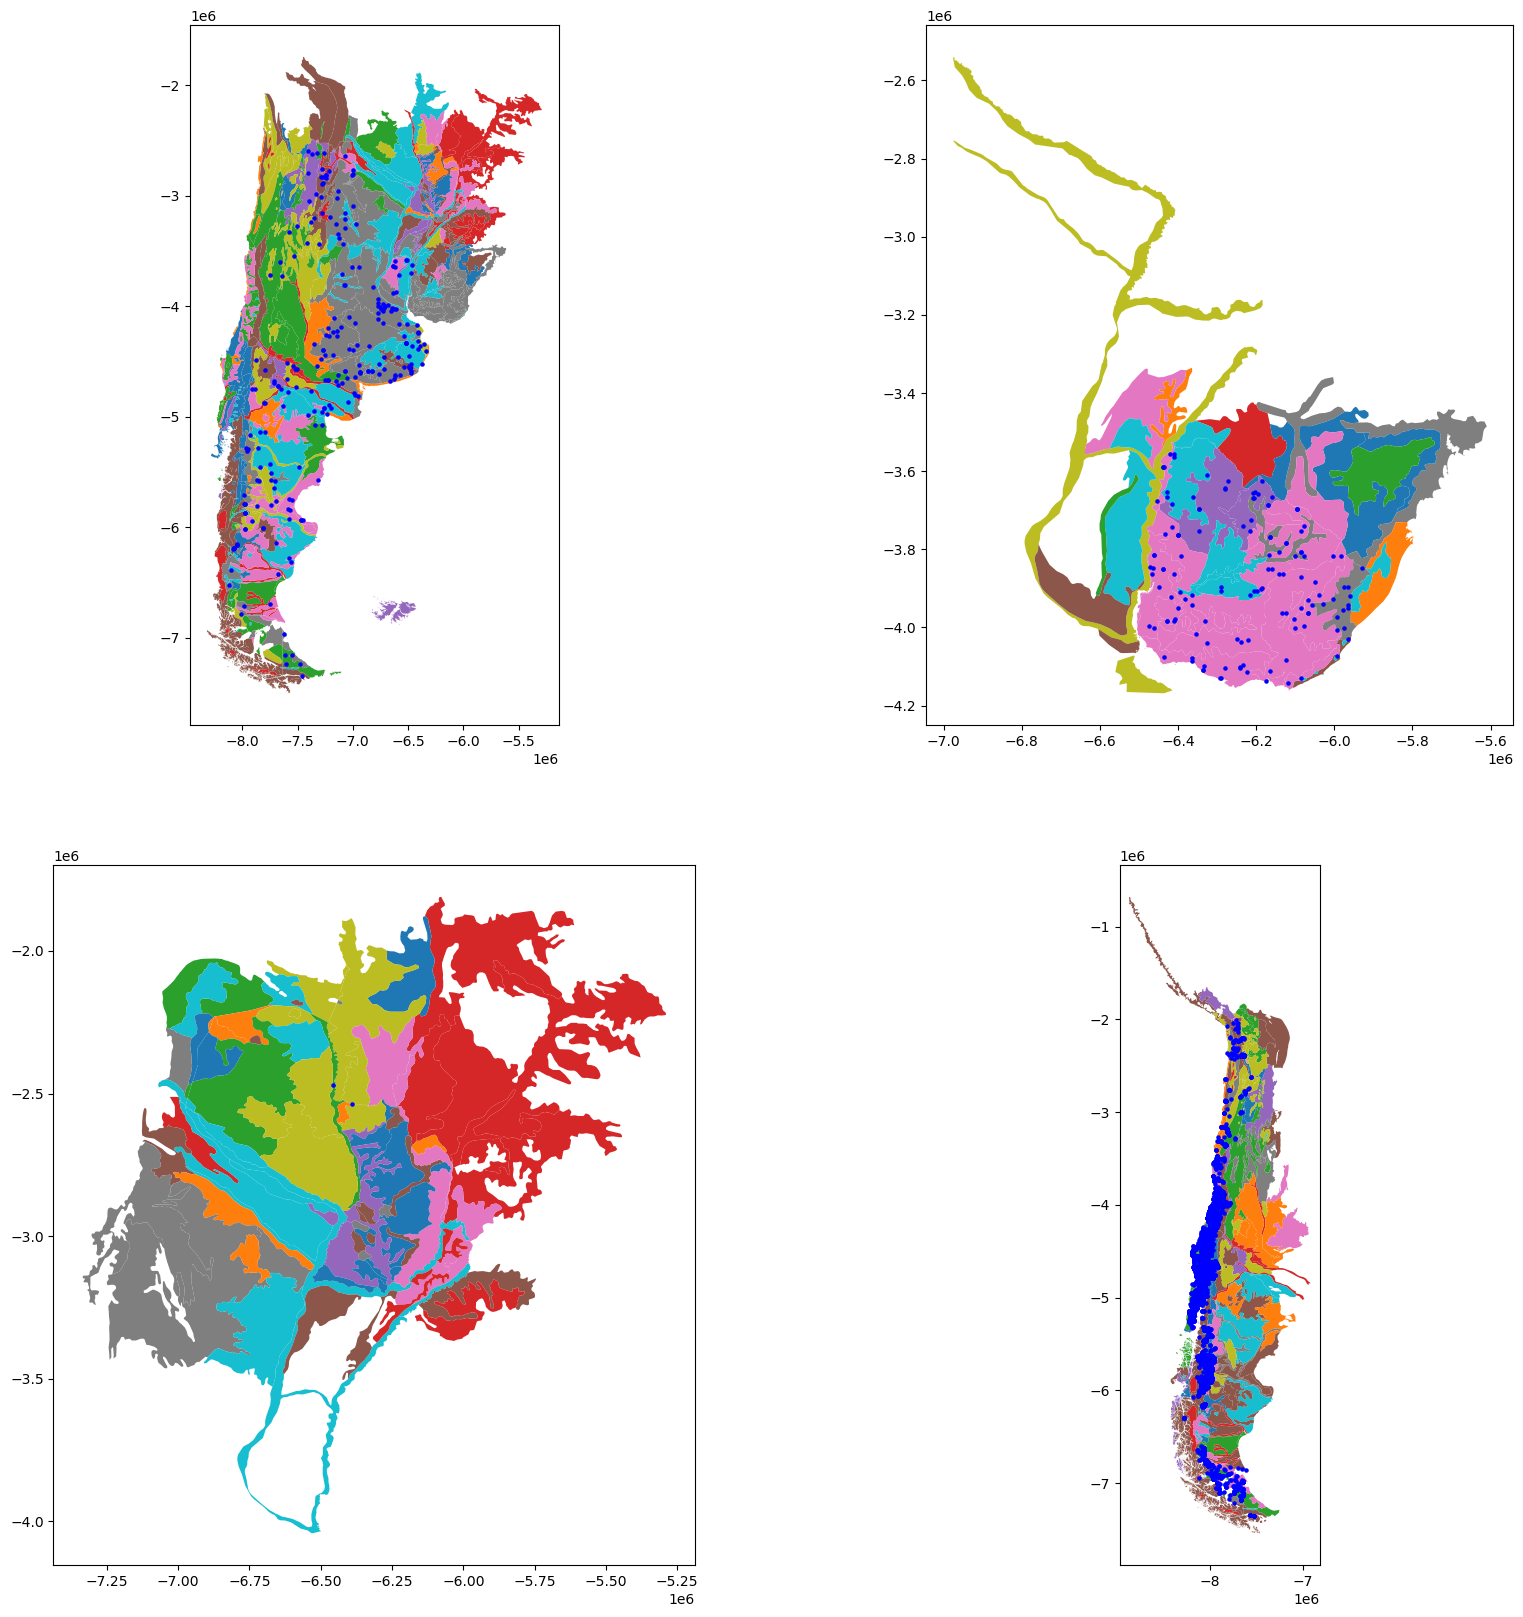

In [76]:
bboxes = get_bboxes_and_transform()
profiles = get_profiles_and_transform()
n = 2

fig, axes = plt.subplots(n, n, figsize=(20,20))

for i in range(n):
    for j in range(n):
        bbox = bboxes[j+i*n]
        base = gdf_soils.cx[bbox[0]:bbox[2], bbox[1]:bbox[3]].plot(column='DOMSOIL_UN', ax=axes[i][j])
        profiles[j+i*n].plot(ax=base, marker='o', color='blue', markersize=5)

# Zonas de suelo cruzadas con Zonas ecologicas

In [108]:
gdf_all_zones = gdf_ecoregions.sjoin(gdf_soils, predicate='overlaps', how='inner')
gdf_all_zones

AREA_left  PERIMETER_left  SA_ECO_ALB  SA_ECO_A_1  LEVEL3  LEVEL2  \
0     1.807720e+06         6852.72           2           2  16.1.1    16.1   
1     5.750910e+05         3528.49           3           3  16.1.1    16.1   
2     8.309400e+05         6550.06           4           4  16.1.1    16.1   
3     2.268020e+06         8768.95           5           5  16.1.1    16.1   
4     2.132550e+06         7619.32           6           8  16.1.1    16.1   
...            ...             ...         ...         ...     ...     ...   
3504  2.234300e+10      1136780.00        2948        2874  24.2.3    24.2   
3504  2.234300e+10      1136780.00        2948        2874  24.2.3    24.2   
3505  4.117020e+07        33585.40        3054        2975  24.2.3    24.2   
3506  7.603690e+05         4062.69        3080        2996  24.2.3    24.2   
3507  1.297330e+06         5108.22        3082        2989  24.2.3    24.2   

      LEVEL1    Shape_Leng    Shape_Area  \
0         16  6.852716e+03  1.807722e+06   
1         16  3.528488e+03  5.750906e+05   
2         16  6.550065e+03  8.309403e+05   
3         16  8.768953e+03  2.268015e+06   
4         16  7.619325e+03  2.132549e+06   
...      ...           ...           ...   
3504      24  1.136778e+06  2.234297e+10   
3504      24  1.136778e+06  2.234297e+10   
3505      24  3.358536e+04  4.117020e+07   
3506      24  4.062688e+03  7.603687e+05   
3507      24  5.108219e+03  1.297331e+06   

                                               geometry  ... PERIMETER_right  \
0     POLYGON ((-8720656.388 3150681.035, -8721114.0...  ...     5992.269306   
1     POLYGON ((-8718599.338 3150123.543, -8719313.6...  ...     3106.338350   
2     POLYGON ((-8711778.752 3146834.784, -8712921.8...  ...     5211.476350   
3     POLYGON ((-8692280.388 3137047.939, -8692880.1...  ...     7971.780201   
4     POLYGON ((-8652987.468 3128291.714, -8653382.4...  ...     6575.923638   
...                                                 ...  ...             ...   
3504  POLYGON ((-7791278.022 -7116020.671, -7790147....  ...   278525.748007   
3504  POLYGON ((-7791278.022 -7116020.671, -7790147....  ...   473977.000748   
3505  POLYGON ((-7879534.756 -6966739.997, -7880323....  ...    37947.233647   
3506  POLYGON ((-7858110.392 -6968924.957, -7858512....  ...     4662.588883   
3507  POLYGON ((-7833759.184 -6973924.888, -7834024....  ...     5836.272714   

     SOTERLAC_  SOTERLAC_I  NEWSUID  LANDFORM  PARENT_MAT  NUMB_SOILC  \
0          177         175     TC25        LP         SO1         2.0   
1          178         176     BS25        LP         SO1         2.0   
2          179         177     TC25        LP         SO1         2.0   
3          182         180     TC25        LP         SO1         2.0   
4          188         186     BS25        LP         SO1         2.0   
...        ...         ...      ...       ...         ...         ...   
3504      5386        5383     CL51        SH          UG         2.0   
3504      5317        5314      CL8        LP          UG         2.0   
3505      5403        5400      CL8        LP          UG         2.0   
3506      5407        5404      CL8        LP          UG         2.0   
3507      5409        5406     CL51        SH          UG         2.0   

     COV_PERC_D DOMSOIL_UN DOMSOIL_WR  
0          60.0        LPe       None  
1          60.0        RGc       None  
2          60.0        LPe       None  
3          60.0        LPe       None  
4          60.0        RGc       None  
...         ...        ...        ...  
3504       60.0        CMu       None  
3504       60.0        PHh       None  
3505       60.0        PHh       None  
3506       60.0        PHh       None  
3507       60.0        CMu       None  

[6491 rows x 24 columns]

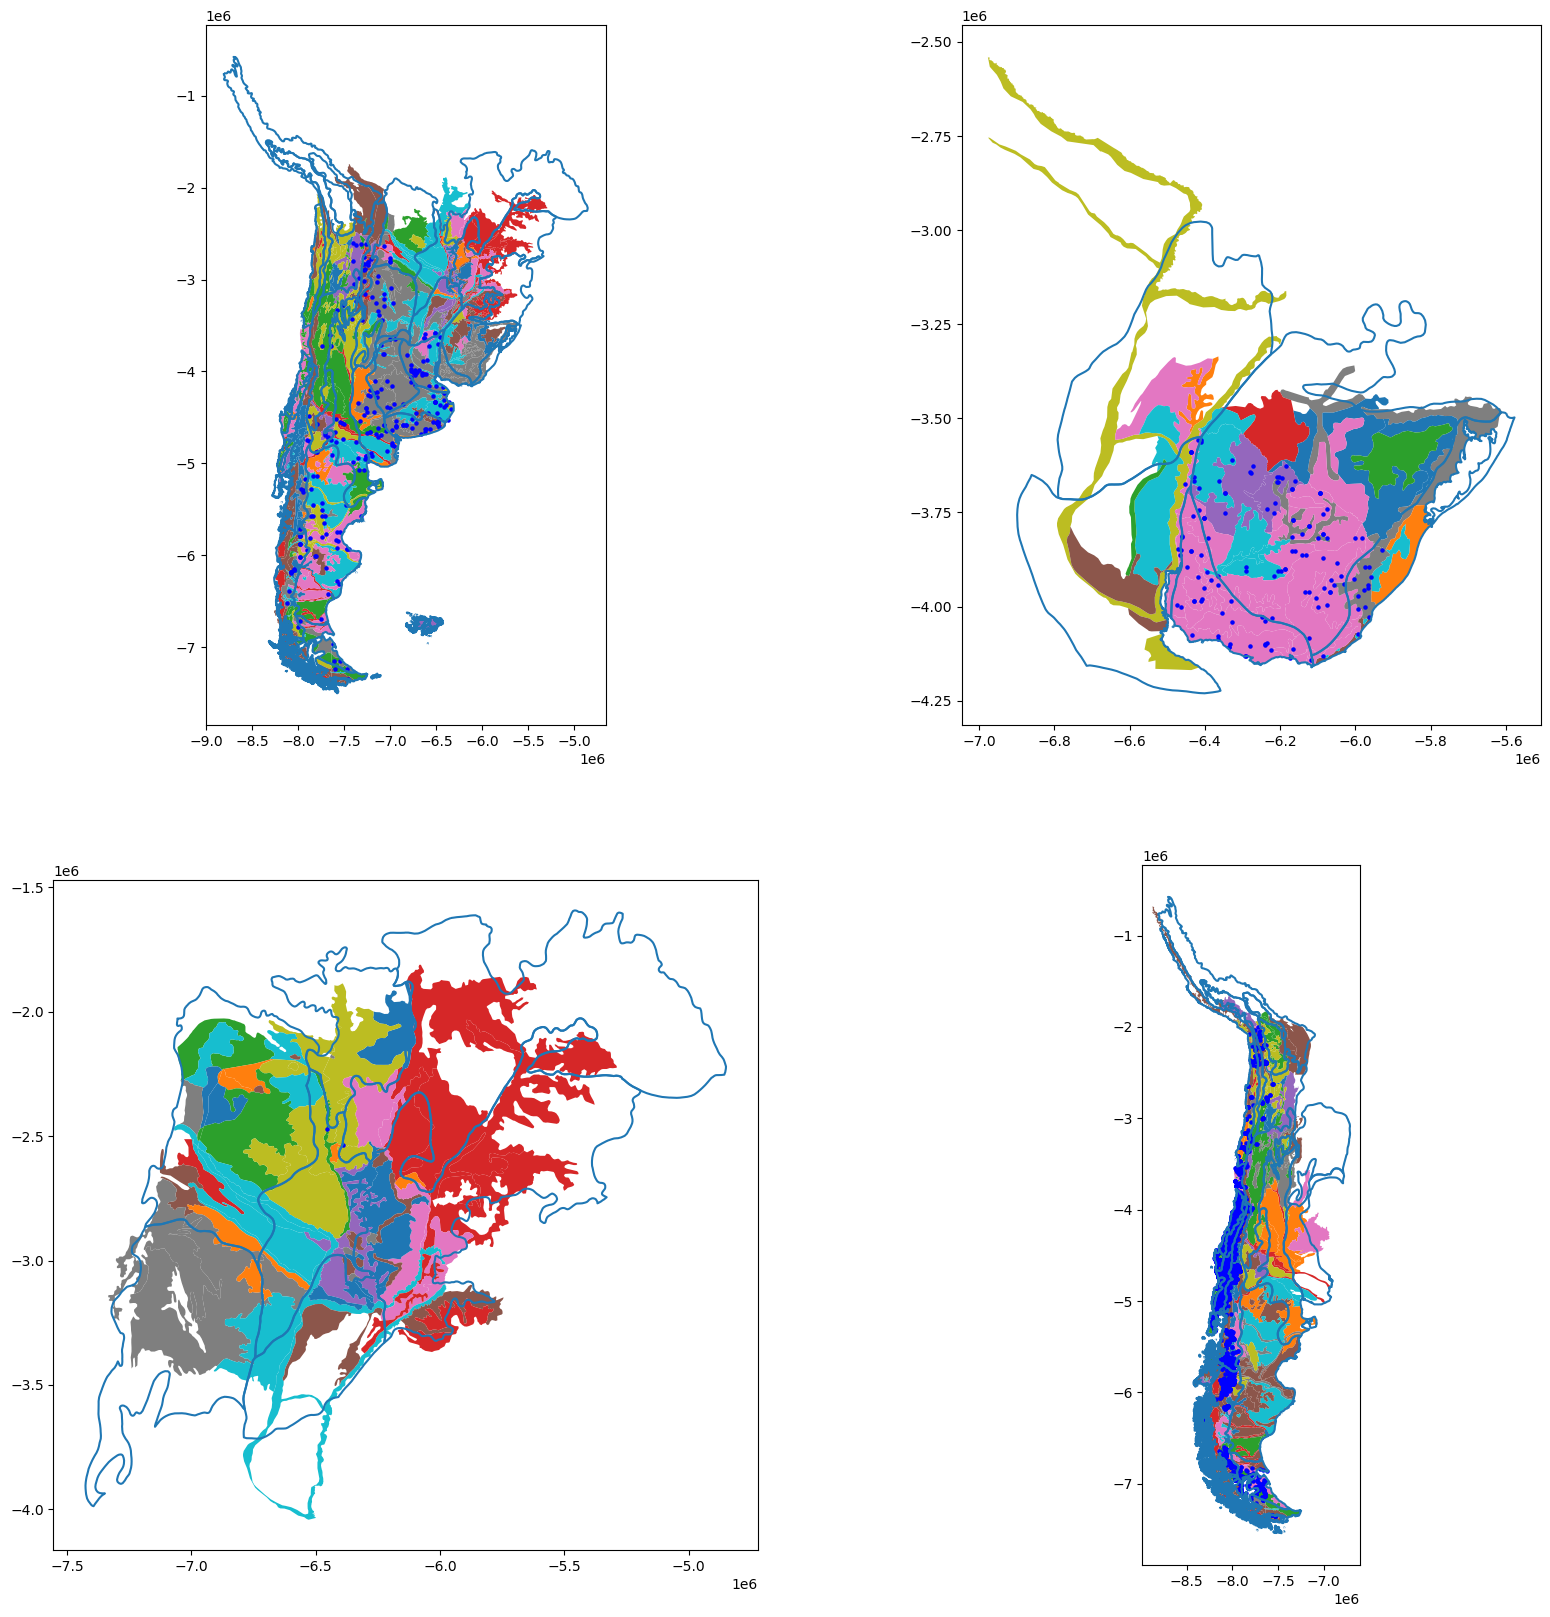

In [81]:
bboxes = get_bboxes_and_transform()
profiles = get_profiles_and_transform()
n = 2

fig, axes = plt.subplots(n, n, figsize=(20,20))

for i in range(n):
    for j in range(n):
        bbox = bboxes[j+i*n]
        base = gdf_soils.cx[bbox[0]:bbox[2], bbox[1]:bbox[3]].plot(column='DOMSOIL_UN', ax=axes[i][j])
        gdf_ecoregions.cx[bbox[0]:bbox[2], bbox[1]:bbox[3]].boundary.plot(ax = base)
        profiles[j+i*n].plot(ax=base, marker='o', color='blue', markersize=5)

In [98]:
gdf_ecoregions

AREA   PERIMETER  SA_ECO_ALB  SA_ECO_A_1  LEVEL3  LEVEL2  \
0     1.807720e+06     6852.72           2           2  16.1.1    16.1   
1     5.750910e+05     3528.49           3           3  16.1.1    16.1   
2     8.309400e+05     6550.06           4           4  16.1.1    16.1   
3     2.268020e+06     8768.95           5           5  16.1.1    16.1   
4     2.132550e+06     7619.32           6           8  16.1.1    16.1   
...            ...         ...         ...         ...     ...     ...   
3503  2.094940e+10   923655.00        2690        2745  24.2.3    24.2   
3504  2.234300e+10  1136780.00        2948        2874  24.2.3    24.2   
3505  4.117020e+07    33585.40        3054        2975  24.2.3    24.2   
3506  7.603690e+05     4062.69        3080        2996  24.2.3    24.2   
3507  1.297330e+06     5108.22        3082        2989  24.2.3    24.2   

      LEVEL1    Shape_Leng    Shape_Area  \
0         16  6.852716e+03  1.807722e+06   
1         16  3.528488e+03  5.750906e+05   
2         16  6.550065e+03  8.309403e+05   
3         16  8.768953e+03  2.268015e+06   
4         16  7.619325e+03  2.132549e+06   
...      ...           ...           ...   
3503      24  9.236554e+05  2.094940e+10   
3504      24  1.136778e+06  2.234297e+10   
3505      24  3.358536e+04  4.117020e+07   
3506      24  4.062688e+03  7.603687e+05   
3507      24  5.108219e+03  1.297331e+06   

                                               geometry   level  \
0     POLYGON ((-8720656.388 3150681.035, -8721114.0...  16.1.1   
1     POLYGON ((-8718599.338 3150123.543, -8719313.6...  16.1.1   
2     POLYGON ((-8711778.752 3146834.784, -8712921.8...  16.1.1   
3     POLYGON ((-8692280.388 3137047.939, -8692880.1...  16.1.1   
4     POLYGON ((-8652987.468 3128291.714, -8653382.4...  16.1.1   
...                                                 ...     ...   
3503  POLYGON ((-8027297.126 -6660834.731, -8011634....  24.2.3   
3504  POLYGON ((-7791278.022 -7116020.671, -7790147....  24.2.3   
3505  POLYGON ((-7879534.756 -6966739.997, -7880323....  24.2.3   
3506  POLYGON ((-7858110.392 -6968924.957, -7858512....  24.2.3   
3507  POLYGON ((-7833759.184 -6973924.888, -7834024....  24.2.3   

                zone_name  
0                 Bahamas  
1                 Bahamas  
2                 Bahamas  
3                 Bahamas  
4                 Bahamas  
...                   ...  
3503  Magellan Grasslands  
3504  Magellan Grasslands  
3505  Magellan Grasslands  
3506  Magellan Grasslands  
3507  Magellan Grasslands  

[3508 rows x 12 columns]

In [145]:
profiles = pd.read_csv('profile_summary.csv')
df_uy = profiles[profiles['country_name'] == 'Uruguay'].copy()
df_uy.drop('Unnamed: 0', axis=1, inplace=True)
df_uy = df_uy.merge(gdf_bd_pond_uy[['profile_id', 'latitude', 'longitude', 'bd_0_30_ponderated']], on='profile_id')
df_uy['bd_0_30_soilgrids'] = df_uy['bd_0_30_ponderated'].apply(lambda x: x[0])
df_uy.drop('bd_0_30_ponderated', axis=1, inplace=True)
df_uy.head(5)

profile_id country_name  clay_pond_val  bdfi33_pond_val  orgc_pond_val  \
0       67749      Uruguay      26.066667              NaN      22.416667   
1       68611      Uruguay      15.000000              NaN       9.800000   
2       68640      Uruguay      21.666667              NaN      12.033333   
3       68641      Uruguay      10.666667              NaN      10.300000   
4       68643      Uruguay       2.000000              NaN       2.100000   

    latitude  longitude  bd_0_30_soilgrids  
0 -30.416667 -57.666667           1.496667  
1 -31.250000 -55.333333           1.481667  
2 -32.750000 -55.083333           1.430000  
3 -31.916667 -55.833333           1.500000  
4 -34.000000 -53.583333           1.185000

In [146]:
gdf_uy = gpd.GeoDataFrame(df_uy, geometry=gpd.points_from_xy(df_uy.longitude, df_uy.latitude)).set_crs("EPSG:4326").to_crs("EPSG:3857")

In [147]:
gdf_uy

profile_id country_name  clay_pond_val  bdfi33_pond_val  orgc_pond_val  \
0         67749      Uruguay      26.066667              NaN      22.416667   
1         68611      Uruguay      15.000000              NaN       9.800000   
2         68640      Uruguay      21.666667              NaN      12.033333   
3         68641      Uruguay      10.666667              NaN      10.300000   
4         68643      Uruguay       2.000000              NaN       2.100000   
..          ...          ...            ...              ...            ...   
131      177131      Uruguay      29.920000         2.548000      32.640000   
132      177132      Uruguay      34.566667         3.046667      19.866667   
133      623792      Uruguay            NaN              NaN       1.733333   
134      177119      Uruguay      51.773333         0.990000            NaN   
135       68642      Uruguay       4.000000              NaN            NaN   

      latitude  longitude  bd_0_30_soilgrids  \
0   -30.416667 -57.666667           1.496667   
1   -31.250000 -55.333333           1.481667   
2   -32.750000 -55.083333           1.430000   
3   -31.916667 -55.833333           1.500000   
4   -34.000000 -53.583333           1.185000   
..         ...        ...                ...   
131 -33.664417 -56.861832           1.453333   
132 -34.342362 -57.809029           1.550000   
133 -34.616665 -55.383335           1.355000   
134 -31.257084 -57.144333           1.565000   
135 -34.800000 -55.466667           0.000000   

                              geometry  
0    POINT (-6419423.969 -3557221.685)  
1    POINT (-6159678.490 -3665259.141)  
2    POINT (-6131848.617 -3862167.465)  
3    POINT (-6215338.236 -3752376.797)  
4    POINT (-5964869.381 -4028802.026)  
..                                 ...  
131  POINT (-6329830.150 -3983829.987)  
132  POINT (-6435271.627 -4074865.976)  
133  POINT (-6165244.663 -4111908.690)  
134  POINT (-6361278.040 -3666181.582)  
135  POINT (-6174521.090 -4136735.049)  

[136 rows x 9 columns]

In [148]:
gdf_all_uy = gdf_uy.sjoin(gdf_all_zones[['zone_name', 'SOTERLAC_', 'geometry']], how='inner', predicate='within')

In [150]:
gdf_all_uy.drop(['index_right', 'latitude', 'longitude'], axis=1, inplace=True)

In [155]:
gdf_all_uy

profile_id country_name  clay_pond_val  bdfi33_pond_val  orgc_pond_val  \
0         67749      Uruguay      26.066667              NaN      22.416667   
26        68665      Uruguay      18.400000              NaN      12.480000   
27        68666      Uruguay      20.000000              NaN      10.800000   
53        68692      Uruguay      45.666667              NaN      18.066667   
87        70568      Uruguay       8.800000              NaN       9.666667   
..          ...          ...            ...              ...            ...   
130      177130      Uruguay      43.633333         1.401333      31.810000   
131      177131      Uruguay      29.920000         2.548000      32.640000   
132      177132      Uruguay      34.566667         3.046667      19.866667   
133      623792      Uruguay            NaN              NaN       1.733333   
135       68642      Uruguay       4.000000              NaN            NaN   

     bd_0_30_soilgrids                           geometry  \
0             1.496667  POINT (-6419423.969 -3557221.685)   
26            0.000000  POINT (-6437977.217 -3589534.709)   
27            0.000000  POINT (-6437977.217 -3589534.709)   
53            1.398333  POINT (-6465807.090 -3862167.465)   
87            1.541667  POINT (-6464291.908 -3848938.934)   
..                 ...                                ...   
130           1.560000  POINT (-6417834.642 -3920894.389)   
131           1.453333  POINT (-6329830.150 -3983829.987)   
132           1.550000  POINT (-6435271.627 -4074865.976)   
133           1.355000  POINT (-6165244.663 -4111908.690)   
135           0.000000  POINT (-6174521.090 -4136735.049)   

                      zone_name  SOTERLAC_  
0    La Plata / Uruguay Lowland       3710  
26   La Plata / Uruguay Lowland       3710  
27   La Plata / Uruguay Lowland       3710  
53   La Plata / Uruguay Lowland       3710  
87   La Plata / Uruguay Lowland       3710  
..                          ...        ...  
130    Southern Uruguay Lowland       4079  
131    Southern Uruguay Lowland       4079  
132    Southern Uruguay Lowland       4079  
133    Southern Uruguay Lowland       4079  
135    Southern Uruguay Lowland       4079  

[3314 rows x 9 columns]

In [156]:
gdf_all_uy[gdf_all_uy['profile_id'] == 623792]

profile_id country_name  clay_pond_val  bdfi33_pond_val  orgc_pond_val  \
133      623792      Uruguay            NaN              NaN       1.733333   
133      623792      Uruguay            NaN              NaN       1.733333   
133      623792      Uruguay            NaN              NaN       1.733333   
133      623792      Uruguay            NaN              NaN       1.733333   
133      623792      Uruguay            NaN              NaN       1.733333   
133      623792      Uruguay            NaN              NaN       1.733333   
133      623792      Uruguay            NaN              NaN       1.733333   
133      623792      Uruguay            NaN              NaN       1.733333   
133      623792      Uruguay            NaN              NaN       1.733333   
133      623792      Uruguay            NaN              NaN       1.733333   
133      623792      Uruguay            NaN              NaN       1.733333   
133      623792      Uruguay            NaN              NaN       1.733333   

     bd_0_30_soilgrids                           geometry  \
133              1.355  POINT (-6165244.663 -4111908.690)   
133              1.355  POINT (-6165244.663 -4111908.690)   
133              1.355  POINT (-6165244.663 -4111908.690)   
133              1.355  POINT (-6165244.663 -4111908.690)   
133              1.355  POINT (-6165244.663 -4111908.690)   
133              1.355  POINT (-6165244.663 -4111908.690)   
133              1.355  POINT (-6165244.663 -4111908.690)   
133              1.355  POINT (-6165244.663 -4111908.690)   
133              1.355  POINT (-6165244.663 -4111908.690)   
133              1.355  POINT (-6165244.663 -4111908.690)   
133              1.355  POINT (-6165244.663 -4111908.690)   
133              1.355  POINT (-6165244.663 -4111908.690)   

                    zone_name  SOTERLAC_  
133  Southern Uruguay Lowland       4040  
133  Southern Uruguay Lowland       4050  
133  Southern Uruguay Lowland       4020  
133  Southern Uruguay Lowland       4012  
133  Southern Uruguay Lowland       4030  
133  Southern Uruguay Lowland       3997  
133  Southern Uruguay Lowland       3993  
133  Southern Uruguay Lowland       3976  
133  Southern Uruguay Lowland       4072  
133  Southern Uruguay Lowland       4039  
133  Southern Uruguay Lowland       4063  
133  Southern Uruguay Lowland       4079